In [1]:
"""
Mini-ImageNet Data Module for Vision Transformer Training
Loads Mini-ImageNet dataset from Hugging Face datasets library
"""

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
import numpy as np
from PIL import Image
from typing import Tuple, Optional, Dict, Any
import torch.nn as nn
import torch.nn.functional as F


class MiniImageNetDataset(Dataset):
    """
    PyTorch Dataset class for Mini-ImageNet from Hugging Face datasets
    """

    def __init__(
        self,
        split: str = "train",
        transform: Optional[transforms.Compose] = None,
        cache_dir: Optional[str] = None
    ):
        """
        Initialize Mini-ImageNet dataset

        Args:
            split: Dataset split - 'train', 'validation', or 'test'
            transform: Torchvision transforms to apply
            cache_dir: Directory to cache downloaded dataset
        """
        self.split = split
        self.transform = transform

        # Load dataset from Hugging Face
        print(f"Loading Mini-ImageNet {split} split from Hugging Face...")
        self.dataset = load_dataset("zh-plus/tiny-imagenet", split=split, cache_dir=cache_dir)

        print(f"Loaded {len(self.dataset)} samples")

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Get a sample from the dataset

        Args:
            idx: Index of the sample

        Returns:
            Tuple of (image_tensor, label)
        """
        sample = self.dataset[idx]

        # Get image and label
        image = sample['image']  # PIL Image
        label = sample['label']  # int

        # Convert grayscale to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
        else:
            # Default: convert PIL to tensor
            image = transforms.ToTensor()(image)

        return image, label


class MiniImageNetDataModule:
    """
    Data module to handle Mini-ImageNet dataset loading and preprocessing
    """

    def __init__(
        self,
        batch_size: int = 32,
        num_workers: int = 4,
        image_size: int = 256,
        cache_dir: Optional[str] = None,
        augment_train: bool = True
    ):
        """
        Initialize Mini-ImageNet data module

        Args:
            batch_size: Batch size for data loaders
            num_workers: Number of workers for data loading
            image_size: Size to resize images (default 256 for Mini-ImageNet)
            cache_dir: Directory to cache dataset
            augment_train: Whether to apply data augmentation to training set
        """
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.image_size = image_size
        self.cache_dir = cache_dir
        self.augment_train = augment_train

        # Setup transforms
        self.setup_transforms()

        # Initialize datasets
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def setup_transforms(self):
        """Setup data transforms for training, validation, and testing"""

        # Base transforms for validation/test
        # Using bilinear interpolation (default) for high-quality resizing
        base_transforms = [
            # transforms.Resize((self.image_size, self.image_size), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]

        # Training transforms with augmentation
        if self.augment_train:
            train_transforms = [
                # Resize to slightly larger size for random crop
                # transforms.Resize(int(self.image_size * 1.15), interpolation=transforms.InterpolationMode.BILINEAR),
                # transforms.RandomCrop(self.image_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                # Random erasing for better generalization
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.RandomErasing(p=0.2, scale=(0.02, 0.15))
            ]
            self.train_transform = transforms.Compose(train_transforms)
        else:
            self.train_transform = transforms.Compose(base_transforms)

        # Validation/Test transforms (no augmentation)
        self.val_transform = transforms.Compose(base_transforms)
        self.test_transform = transforms.Compose(base_transforms)

    def setup_datasets(self):
        """Setup train, validation, and test datasets"""
        print("Setting up Mini-ImageNet datasets...")

        self.train_dataset = MiniImageNetDataset(
            split="train",
            transform=self.train_transform,
            cache_dir=self.cache_dir
        )

        self.val_dataset = MiniImageNetDataset(
            split="valid",
            transform=self.val_transform,
            cache_dir=self.cache_dir
        )

        # self.test_dataset = MiniImageNetDataset(
        #     split="test",
        #     transform=self.test_transform,
        #     cache_dir=self.cache_dir
        # )

        print(f"Train dataset: {len(self.train_dataset)} samples")
        print(f"Validation dataset: {len(self.val_dataset)} samples")
        # print(f"Test dataset: {len(self.test_dataset)} samples")

    def get_dataloaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        """
        Get train, validation, and test data loaders

        Returns:
            Tuple of (train_loader, val_loader, test_loader)
        """
        if self.train_dataset is None or self.val_dataset is None or self.test_dataset is None:
            self.setup_datasets()

        train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            drop_last=True  # For stable batch norm statistics
        )

        val_loader = DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        # test_loader = DataLoader(
        #     self.test_dataset,
        #     batch_size=self.batch_size,
        #     shuffle=False,
        #     num_workers=self.num_workers,
        #     pin_memory=True
        # )

        return train_loader, val_loader

    def get_sample_batch(self, split: str = "train") -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get a sample batch for testing

        Args:
            split: Which split to sample from ('train', 'validation', or 'test')

        Returns:
            Tuple of (images, labels) tensors
        """
        if self.train_dataset is None or self.val_dataset is None or self.test_dataset is None:
            self.setup_datasets()

        if split == "train":
            dataset = self.train_dataset
        elif split == "validation" or split == "valid":
            dataset = self.val_dataset
        else:
            dataset = self.test_dataset

        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        return next(iter(loader))


if __name__ == "__main__":
    # Test the data module
    print("Testing Mini-ImageNet Data Module")
    print("=" * 50)

    # Create data module
    data_module = MiniImageNetDataModule(
        batch_size=16,
        num_workers=2,
        image_size=256,
        augment_train=True
    )

    # Setup datasets
    data_module.setup_datasets()

    # Get basic info
    print(f"\nDataset Information:")
    print(f"Train dataset size: {len(data_module.train_dataset)}")
    print(f"Validation dataset size: {len(data_module.val_dataset)}")
    # print(f"Test dataset size: {len(data_module.test_dataset)}")
    print(f"Number of classes: 100")

    # Get a sample from train dataset
    print(f"\nSample from training set:")
    image, label = data_module.train_dataset[0]
    print(f"Image shape: {image.shape}")
    print(f"Image dtype: {image.dtype}")
    print(f"Label: {label}")
    print(f"Image min/max values: {image.min():.3f} / {image.max():.3f}")

    # Get a sample batch
    print(f"\nSample batch:")
    images, labels = data_module.get_sample_batch("train")
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    print(f"First 5 labels: {labels[:5].tolist()}")

    # Test data loaders
    print(f"\nTesting data loaders:")
    train_loader, val_loader = data_module.get_dataloaders()
    print(f"Train loader batches: {len(train_loader)}")
    print(f"Validation loader batches: {len(val_loader)}")
    # print(f"Test loader batches: {len(test_loader)}")

    # Test a few batches
    print(f"\nTesting first batch from train loader:")
    batch_images, batch_labels = next(iter(train_loader))
    print(f"Batch shape: {batch_images.shape}")
    print(f"Labels shape: {batch_labels.shape}")

    print(f"\nTesting first batch from validation loader:")
    batch_images, batch_labels = next(iter(val_loader))
    print(f"Batch shape: {batch_images.shape}")
    print(f"Labels shape: {batch_labels.shape}")

    print(f"\nMini-ImageNet Data Module test completed successfully!")

/home/bilal/Research/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Testing Mini-ImageNet Data Module
Setting up Mini-ImageNet datasets...
Loading Mini-ImageNet train split from Hugging Face...
Loaded 100000 samples
Loading Mini-ImageNet valid split from Hugging Face...
Loaded 10000 samples
Train dataset: 100000 samples
Validation dataset: 10000 samples

Dataset Information:
Train dataset size: 100000
Validation dataset size: 10000
Number of classes: 100

Sample from training set:
Image shape: torch.Size([3, 64, 64])
Image dtype: torch.float32
Label: 0
Image min/max values: -2.118 / 2.640

Sample batch:
Setting up Mini-ImageNet datasets...
Loading Mini-ImageNet train split from Hugging Face...
Loaded 100000 samples
Loading Mini-ImageNet valid split from Hugging Face...
Loaded 10000 samples
Train dataset: 100000 samples
Validation dataset: 10000 samples
Batch images shape: torch.Size([16, 3, 64, 64])
Batch labels shape: torch.Size([16])
First 5 labels: [0, 0, 0, 0, 0]

Testing data loaders:
Setting up Mini-ImageNet datasets...
Loading Mini-ImageNet trai

In [4]:
class ModulatedMultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention with latent token modulation and learnable aggregation.
    """
    def __init__(self, dim, num_latents, num_heads=1, qkv_bias=True, dropout=0.0,
                 modulate_v=True, aggregation='max'):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} must be divisible by num_heads {num_heads}"
        assert aggregation in ['mean', 'max', 'learned_weight', 'attention', 'gated'], \
            f"aggregation must be one of ['mean', 'max', 'learned_weight', 'attention', 'gated'], got {aggregation}"
        
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.modulate_v = modulate_v
        self.aggregation = aggregation
        self.num_latents = num_latents
        
        # --- VISUALIZATION STATE ---
        self.save_indices = False
        self.saved_indices = None
        # ---------------------------
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(dropout)
        # self.proj = nn.Linear(dim, dim)
        # self.proj_drop = nn.Dropout(dropout)
    
    def aggregate_tokens(self, tokens):
        if self.aggregation == 'mean':
            return tokens.mean(dim=2, keepdim=True)
        elif self.aggregation == 'max':
            max_tokens, indices = tokens.topk(12, dim=3) # hardcoded 12 for imagenet-1k
            return max_tokens, indices
        elif self.aggregation == 'learned_weight':
            weights = self.aggregation_weight(tokens)
            weights = F.softmax(weights, dim=2)
            weighted = tokens * weights
            return weighted.sum(dim=2, keepdim=True)
        elif self.aggregation == 'attention':
            query = tokens.mean(dim=2, keepdim=True)
            query = self.agg_query(query)
            scores = (query @ tokens.transpose(-2, -1)) * self.agg_scale
            attn_weights = F.softmax(scores, dim=-1)
            aggregated = attn_weights @ tokens
            return aggregated
        elif self.aggregation == 'gated':
            gates = self.gate_net(tokens)
            gated = tokens * gates
            return gated.mean(dim=2, keepdim=True)
        else:
            raise ValueError(f"Unknown aggregation: {self.aggregation}")
    
    def modulate_cls_token(self, cls_token, other_tokens, same_tokens):
        cls_token = cls_token.unsqueeze(3)
        other_tokens = other_tokens.unsqueeze(2)
        same_tokens = same_tokens.unsqueeze(2)
        interaction = cls_token * other_tokens # Qcls X Kx
        modulated = interaction + same_tokens  # Qx + (Qcls X Kx)
        modulated_cls, indices = self.aggregate_tokens(modulated)
        return modulated_cls.squeeze(2), indices.squeeze(2)
    
    def modulate_v_cls(self, v_cls ,qk_cls, v_full):
        v_squared = v_full ** 2
        two_v = 2 * v_full
        # product of original qcls and kcls are used here, mean of modulated q_cls and k_cls gives slightly better performance
        qk_interaction = qk_cls 
        v_cls_abs = torch.abs(v_cls)
        gating = 1 + v_cls_abs 
        interaction_term = qk_interaction * gating 
        interaction_term = interaction_term.unsqueeze(3)
        v_squared = v_squared.unsqueeze(2)
        two_v = two_v.unsqueeze(2)
        modulated_v = v_squared + two_v + interaction_term
        v_cls_modulated, indices = self.aggregate_tokens(modulated_v)
        return v_cls_modulated.squeeze(2), indices.squeeze(2), modulated_v.squeeze(2)
    
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        L = self.num_latents 
        q_cls, q_patches = q[:, :, 0:L, :], q[:, :, L:, :]
        k_cls, k_patches = k[:, :, 0:L, :], k[:, :, L:, :]
        v_cls, v_patches = v[:, :, 0:L, :], v[:, :, L:, :]
    
        q_cls_modulated, _ = self.modulate_cls_token(q_cls, k_patches, q_patches)
        k_cls_modulated, _ = self.modulate_cls_token(k_cls, q_patches, k_patches)
        v_cls_modulated, v_indices, modulated_v = self.modulate_v_cls(v_cls, q_cls*k_cls, v_patches)

        # --- CAPTURE INDICES (Added for Visualization) ---
        if self.save_indices:
            # v_indices shape is likely (B, H, 12, D)
            self.saved_indices = v_indices.detach().clone()
        # -------------------------------------------------

        q_cls_modulated = torch.cat([q_cls, q_cls_modulated], dim=2)
        k_cls_modulated = torch.cat([k_cls, k_cls_modulated], dim=2)
        v_cls_modulated = torch.cat([v_cls, v_cls_modulated], dim=2)
    
        attn = (q_cls_modulated @ k_cls_modulated.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
    
        out = attn @ v_cls_modulated

        # --- Reconstructing output to match shapes for scatter ---
        out = out.transpose(1, 2).reshape(B, 13, C) 
        out_cls, out_ = out[:, 0], out[:, 1:]  
        
        # Create zeros tensor with same dtype as out_ to avoid AMP dtype mismatch
        skip_v_zeros = torch.zeros_like(modulated_v.squeeze(1), dtype=out_.dtype)  
        
        # v_indices.squeeze(1) is (B, 12, D). out_ is (B, 12, C). C=D. 
        # This scatter maps the Top K features back to their original token positions (dim=1)
        skip_v_zeros = skip_v_zeros.scatter_(dim=1, index=v_indices.squeeze(1), src=out_)

        v_out = modulated_v.squeeze(1).to(out_.dtype) + skip_v_zeros
        v_out = torch.cat([out_cls.unsqueeze(1), v_out], dim=1)
        
        return v_out

class MultiHeadAttention:
    pass


In [5]:
"""
Vision Transformer Block Module
Contains the transformer block with modulated attention, MLP, and layer normalization
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple , List, Union
import math

class MLP(nn.Module):
    """
    Multi-Layer Perceptron (Feed-Forward Network) for Vision Transformer
    """

    def __init__(
        self,
        in_features: int,
        hidden_features: Optional[int] = None,
        out_features: Optional[int] = None,
        activation: nn.Module = nn.GELU,
        dropout: float = 0.0,
        bias: bool = True
    ):
        """
        Args:
            in_features: Input feature dimension
            hidden_features: Hidden layer dimension (default: 4 * in_features)
            out_features: Output feature dimension (default: in_features)
            activation: Activation function
            dropout: Dropout rate
            bias: Whether to use bias in linear layers
        """
        super().__init__()

        out_features = out_features or in_features
        hidden_features = hidden_features or in_features * 4

        self.fc1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.act = activation()
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_features, out_features, bias=bias)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (B, N, C)
        Returns:
            Output tensor of shape (B, N, C)
        """
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x


class HybridTransformerBlock(nn.Module):
    """
    Transformer Block that can use either Modulated or Standard Attention
    """
    
    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        dropout: float = 0.0,
        attn_dropout: float = 0.0,
        drop_path: float = 0.0,
        activation: nn.Module = nn.GELU,
        norm_layer: nn.Module = nn.LayerNorm,
        attention_type: str = 'modulated',  # 'modulated' or 'standard'
        modulate_v: bool = False
    ):
        """
        Args:
            dim: Input embedding dimension
            num_heads: Number of attention heads
            mlp_ratio: Ratio of mlp hidden dim to embedding dim
            qkv_bias: Whether to add bias to qkv projection
            dropout: Dropout rate for MLP
            attn_dropout: Dropout rate for attention
            drop_path: Stochastic depth rate
            activation: Activation function for MLP
            norm_layer: Normalization layer
            attention_type: Type of attention ('modulated' or 'standard')
            modulate_v: Whether to modulate V in modulated attention
        """
        super().__init__()
        
        self.dim = dim
        self.num_heads = num_heads
        self.attention_type = attention_type
        
        # Layer normalization
        self.norm1 = norm_layer(dim)
        self.norm2 = norm_layer(dim)
        
        # Select attention mechanism
        if attention_type == 'modulated':
            self.attn = ModulatedMultiHeadAttention(
                dim=dim,
                num_latents=1,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                dropout=attn_dropout,
                modulate_v=modulate_v
            )
        elif attention_type == 'standard':
            self.attn = MultiHeadAttention(
                dim=dim,
                num_heads=num_heads,
                qkv_bias=qkv_bias,
                dropout=attn_dropout
            )
        else:
            raise ValueError(f"Unknown attention type: {attention_type}. Use 'modulated' or 'standard'")
        
        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            activation=activation,
            dropout=dropout
        )
        
        # Stochastic depth
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
    
    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (B, N, C)
        Returns:
            Output tensor of shape (B, N, C)
        """
        # Attention block with residual connection
        x = x + self.drop_path(self.attn(self.norm1(x)))
        # x = self.drop_path(self.attn(self.norm1(x)))
        
        # MLP block with residual connection
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x
    
    def get_attention_weights(self, x):
        """Get attention weights for visualization"""
        x_norm = self.norm1(x)
        return self.attn.get_attention_weights(x_norm) if hasattr(self.attn, 'get_attention_weights') else None
    
    def extra_repr(self):
        return f'attention_type={self.attention_type}, dim={self.dim}, num_heads={self.num_heads}'

class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample for regularization.
    """

    def __init__(self, drop_prob: float = 0.0):
        """
        Args:
            drop_prob: Probability of dropping a path
        """
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0.0 or not self.training:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()  # binarize
        output = x.div(keep_prob) * random_tensor
        return output

    def extra_repr(self):
        return f'drop_prob={self.drop_prob}'



In [6]:
"""
Complete Vision Transformer Implementation
Includes patch embedding, positional encoding, and full ViT architecture
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple
import math


class PatchEmbedding(nn.Module):
    """
    Image to Patch Embedding
    Converts images into patches and linearly embeds them
    """

    def __init__(
        self,
        image_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        embed_dim: int = 768,
        bias: bool = True
    ):
        """
        Args:
            image_size: Size of input image (assumed square)
            patch_size: Size of each patch (assumed square)
            in_channels: Number of input channels (3 for RGB)
            embed_dim: Embedding dimension
            bias: Whether to use bias in projection layer
        """
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        # Calculate number of patches
        self.num_patches = (image_size // patch_size) ** 2
        self.grid_size = image_size // patch_size

        # Patch embedding using convolution
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
            bias=bias
        )

        # Layer normalization (optional, but often helpful)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (B, C, H, W)
        Returns:
            Patch embeddings of shape (B, num_patches, embed_dim)
        """
        B, C, H, W = x.shape

        # Verify input dimensions
        assert H == self.image_size and W == self.image_size, \
            f"Input image size ({H}, {W}) doesn't match model ({self.image_size}, {self.image_size})"
        assert C == self.in_channels, \
            f"Input channels ({C}) doesn't match model ({self.in_channels})"

        # Extract patches and flatten
        x = self.proj(x)  # (B, embed_dim, grid_size, grid_size)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)

        # Apply layer normalization
        x = self.norm(x)

        return x

    def get_patch_info(self):
        """Return patch embedding information"""
        return {
            'num_patches': self.num_patches,
            'grid_size': self.grid_size,
            'patch_size': self.patch_size,
            'embed_dim': self.embed_dim
        }


class PositionalEmbedding(nn.Module):
    """
    Learnable positional embeddings for Vision Transformer
    """

    def __init__(self, num_patches: int, embed_dim: int, dropout: float = 0.0):
        """
        Args:
            num_patches: Number of patches in the image
            embed_dim: Embedding dimension
            dropout: Dropout rate for positional embeddings
        """
        super().__init__()

        self.num_patches = num_patches
        self.embed_dim = embed_dim

        # Learnable positional embeddings (including CLS token)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.02)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Args:
            x: Patch embeddings of shape (B, num_patches + 1, embed_dim)
        Returns:
            Embeddings with positional encoding of same shape
        """
        return self.dropout(x + self.pos_embed)


class ClassificationHead(nn.Module):
    """
    Classification head for Vision Transformer
    """

    def __init__(
        self,
        embed_dim: int,
        num_classes: int,
        dropout: float = 0.0,
        use_norm: bool = True
    ):
        """
        Args:
            embed_dim: Input embedding dimension
            num_classes: Number of output classes
            dropout: Dropout rate before final linear layer
            use_norm: Whether to apply layer norm before classification
        """
        super().__init__()

        self.embed_dim = embed_dim
        self.num_classes = num_classes

        self.norm = nn.LayerNorm(embed_dim) if use_norm else nn.Identity()
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize with smaller weights for better training stability
        nn.init.trunc_normal_(self.head.weight, std=0.02)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        """
        Args:
            x: CLS token features of shape (B, embed_dim)
        Returns:
            Class logits of shape (B, num_classes)
        """
        x = self.norm(x)
        x = self.dropout(x)
        return self.head(x)


class HybridVisionTransformer(nn.Module):
    """
    Vision Transformer with Hybrid Attention Architecture
    Supports mixing modulated and standard attention layers
    """
    
    def __init__(
        self,
        image_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        num_classes: int = 1000,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 1,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        dropout: float = 0.0,
        attn_dropout: float = 0.0,
        drop_path_rate: float = 0.1,
        attention_pattern: Union[str, List[str]] = 'modulated',
        modulate_v: bool = False,
        norm_layer: nn.Module = nn.LayerNorm,
        activation: nn.Module = nn.GELU
    ):
        """
        Args:
            image_size: Input image size
            patch_size: Patch size for patch embedding
            in_channels: Number of input channels
            num_classes: Number of classification classes
            embed_dim: Embedding dimension
            depth: Number of transformer blocks
            num_heads: Number of attention heads
            mlp_ratio: Ratio of MLP hidden dimension to embedding dimension
            qkv_bias: Whether to add bias to qkv projection
            dropout: Dropout rate
            attn_dropout: Attention dropout rate
            drop_path_rate: Stochastic depth rate
            attention_pattern: Pattern of attention types. Options:
                - 'modulated': All layers use modulated attention
                - 'standard': All layers use standard attention
                - 'alternating': Alternates between modulated and standard
                - 'early_modulated': First half modulated, second half standard
                - 'late_modulated': First half standard, second half modulated
                - List[str]: Explicit list of attention types per layer
            modulate_v: Whether to modulate V in modulated attention layers
            norm_layer: Normalization layer
            activation: Activation function
        """
        super().__init__()
        
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.depth = depth
        
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        
        num_patches = self.patch_embed.num_patches
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        
        # Positional embedding
        self.pos_embed = PositionalEmbedding(
            num_patches=num_patches,
            embed_dim=embed_dim,
            dropout=dropout
        )
        
        # Determine attention pattern for each layer
        attention_types = self._parse_attention_pattern(attention_pattern, depth)
        self.attention_types = attention_types
        
        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        
        # Build transformer blocks with hybrid attention
        self.blocks = nn.ModuleList([
            HybridTransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                dropout=dropout,
                attn_dropout=attn_dropout,
                drop_path=dpr[i],
                activation=activation,
                norm_layer=norm_layer,
                attention_type=attention_types[i],
                modulate_v=modulate_v
            )
            for i in range(depth)
        ])
        
        # Classification head
        self.head = ClassificationHead(
            embed_dim=embed_dim,
            num_classes=num_classes,
            dropout=dropout
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _parse_attention_pattern(self, pattern: Union[str, List[str]], depth: int) -> List[str]:
        """
        Parse attention pattern into a list of attention types per layer
        
        Args:
            pattern: Attention pattern specification
            depth: Number of layers
        
        Returns:
            List of attention types for each layer
        """
        if isinstance(pattern, list):
            assert len(pattern) == depth, f"Pattern list length {len(pattern)} must match depth {depth}"
            return pattern
        
        if pattern == 'modulated':
            return ['modulated'] * depth
        elif pattern == 'standard':
            return ['standard'] * depth
        elif pattern == 'alternating':
            return ['modulated' if i % 2 == 0 else 'standard' for i in range(depth)]
        elif pattern == 'early_modulated':
            mid = depth // 2
            return ['modulated'] * mid + ['standard'] * (depth - mid)
        elif pattern == 'late_modulated':
            mid = depth // 2
            return ['standard'] * mid + ['modulated'] * (depth - mid)
        else:
            raise ValueError(f"Unknown attention pattern: {pattern}")
    
    def _init_weights(self, m):
        """Initialize model weights"""
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward_features(self, x):
        """
        Forward pass through patch embedding, positional encoding, and transformer blocks
        
        Args:
            x: Input images of shape (B, C, H, W)
        Returns:
            Feature tokens of shape (B, num_patches + 1, embed_dim)
        """
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add positional encoding
        x = self.pos_embed(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        return x
    
    def forward(self, x):
        """
        Full forward pass
        
        Args:
            x: Input images of shape (B, C, H, W)
        Returns:
            Class logits of shape (B, num_classes)
        """
        x = self.forward_features(x)
        cls_token = x[:, 0]
        logits = self.head(cls_token)
        return logits
    
    def get_attention_maps(self, x, block_idx: Optional[int] = None):
        """
        Extract attention maps for visualization
        
        Args:
            x: Input images
            block_idx: Which block to extract attention from (None for all)
        Returns:
            Attention maps with layer information
        """
        B = x.shape[0]
        
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = self.pos_embed(x)
        
        attention_maps = []
        
        for i, block in enumerate(self.blocks):
            if block_idx is None or i == block_idx:
                attn_info = block.get_attention_weights(x)
                if attn_info is not None:
                    attention_maps.append({
                        'layer': i,
                        'attention_type': self.attention_types[i],
                        'weights': attn_info[0],
                        'modulation_info': attn_info[1] if len(attn_info) > 1 else None
                    })
            x = block(x)
        
        return attention_maps if len(attention_maps) > 1 else attention_maps[0] if attention_maps else None
    
    def get_model_info(self):
        """Get comprehensive model information including attention pattern"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        # Count attention types
        modulated_count = sum(1 for t in self.attention_types if t == 'modulated')
        standard_count = sum(1 for t in self.attention_types if t == 'standard')
        
        return {
            'image_size': self.image_size,
            'patch_size': self.patch_size,
            'num_patches': self.patch_embed.num_patches,
            'embed_dim': self.embed_dim,
            'depth': self.depth,
            'num_classes': self.num_classes,
            'attention_pattern': self.attention_types,
            'modulated_layers': modulated_count,
            'standard_layers': standard_count,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'model_size_mb': total_params * 4 / 1024**2
        }
    
    def print_architecture(self):
        """Print a visual representation of the architecture"""
        print("=" * 70)
        print(f"Hybrid Vision Transformer Architecture")
        print("=" * 70)
        info = self.get_model_info()
        print(f"Image Size: {info['image_size']}x{info['image_size']}")
        print(f"Patches: {info['num_patches']} ({self.patch_embed.grid_size}x{self.patch_embed.grid_size})")
        print(f"Embedding Dim: {info['embed_dim']}")
        print(f"Total Layers: {info['depth']}")
        print(f"  - Modulated Attention: {info['modulated_layers']}")
        print(f"  - Standard Attention: {info['standard_layers']}")
        print(f"Parameters: {info['total_params']:,} ({info['model_size_mb']:.2f} MB)")
        print("\nLayer-by-Layer Attention Types:")
        print("-" * 70)
        for i, attn_type in enumerate(self.attention_types):
            symbol = "🔷" if attn_type == "modulated" else "⬜"
            print(f"  Layer {i:2d}: {symbol} {attn_type.capitalize()}")
        print("=" * 70)


def create_hybrid_vit(
    model_size: str = 'tiny',
    num_classes: int = 10,
    image_size: int = 32,
    attention_pattern: Union[str, List[str]] = 'modulated',
    modulate_v: bool = False
):
    """
    Factory function to create Hybrid Vision Transformer models
    
    Args:
        model_size: Size of the model ('tiny', 'small', 'base', 'large')
        num_classes: Number of classes for classification
        image_size: Input image size
        attention_pattern: Pattern of attention types
        modulate_v: Whether to modulate V in modulated layers
    
    Returns:
        Hybrid Vision Transformer model
    """
    configs = {
        'tiny': {
            'embed_dim': 192,
            'depth': 12,
            'num_heads': 3,
            'patch_size': 16 if image_size >= 224 else 4,
            'mlp_ratio': 4.0,
            'dropout': 0.0,
            'drop_path_rate': 0.1
        },
        'small': {
            'embed_dim': 384,
            'depth': 2,
            'num_heads': 1,
            'patch_size': 8,
            'mlp_ratio': 4.0,
            'dropout': 0.1,
            'drop_path_rate': 0.1
        },
        'base': {
            'embed_dim': 768,
            'depth': 12,
            'num_heads': 12,
            'patch_size': 16 if image_size >= 224 else 4,
            'mlp_ratio': 4.0,
            'dropout': 0.1,
            'drop_path_rate': 0.1
        }
    }
    
    assert model_size in configs, f"Model size {model_size} not supported"
    config = configs[model_size]
    
    return HybridVisionTransformer(
        image_size=image_size,
        patch_size=config['patch_size'],
        num_classes=num_classes,
        embed_dim=config['embed_dim'],
        depth=config['depth'],
        num_heads=config['num_heads'],
        mlp_ratio=config['mlp_ratio'],
        dropout=config['dropout'],
        drop_path_rate=config['drop_path_rate'],
        attention_pattern=attention_pattern,
        modulate_v=modulate_v
    )


In [ ]:
import wandb
# --- Weights & Biases setup ---
wandb.login(key="")  # add key here

training_config = {
            'embed_dim': 384,
            'depth': 2,
            'head': 1,
            'patch_size': 8,
            'mlp_ratio': 4.0,
            'dropout': 0.1,
            'drop_path_rate': 0.1
        }

wandb.init(
    project="",       # W&B project name
    name="",      # optional descriptive run name
    config=training_config
)

MiniImageNetData Vision Transformer Training
Setting up data...
Setting up Mini-ImageNet datasets...
Loading Mini-ImageNet train split from Hugging Face...
Loaded 100000 samples
Loading Mini-ImageNet valid split from Hugging Face...


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Loaded 10000 samples
Train dataset: 100000 samples
Validation dataset: 10000 samples
Train batches: 781
Test batches: 79

Creating Vision Transformer model...
Model created:
  Parameters: 3,726,920
  Model size: 14.22 MB
  Patches: 64

Training configuration:
  num_epochs: 30
  learning_rate: 0.0003
  weight_decay: 0.05
  optimizer_name: adamw
  scheduler_name: cosine
  device: cuda
  save_path: ./vit_checkpoints
  print_freq: 20
  save_freq: 5

🚀 Starting training...
Training on device: cuda
Model parameters: 3,726,920
👀 W&B: Watching model gradients...

Starting training for 30 epochs...

Epoch [  1/ 30]
----------------------------------------
  Batch [  0/781] | Loss: 5.3966 | Acc: 0.0000 | LR: 0.000300 | Time: 0.3s
  Batch [ 20/781] | Loss: 5.2771 | Acc: 0.0156 | LR: 0.000300 | Time: 2.1s
  Batch [ 40/781] | Loss: 5.2701 | Acc: 0.0000 | LR: 0.000300 | Time: 3.6s
  Batch [ 60/781] | Loss: 5.1093 | Acc: 0.0156 | LR: 0.000300 | Time: 5.2s
  Batch [ 80/781] | Loss: 5.0695 | Acc: 0.031

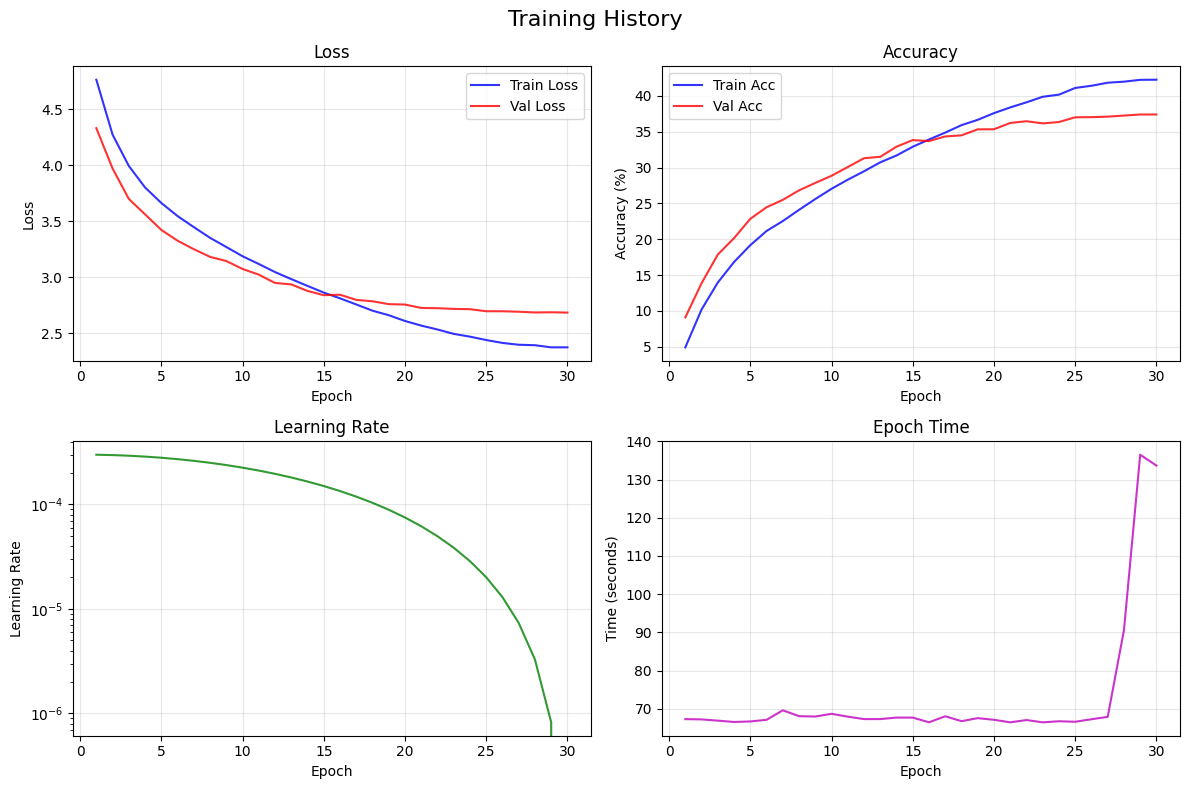


FINAL TESTING
Testing model on test set...


IndexError: list index out of range

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import time
import os
from typing import Dict, List, Tuple, Optional
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
import time
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import wandb
from typing import List, Optional

class TrainingMetrics:
    """Class to track training metrics"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.learning_rates = []
        self.epoch_times = []

    def update_train(self, loss: float, accuracy: float, lr: float):
        self.train_losses.append(loss)
        self.train_accuracies.append(accuracy)
        self.learning_rates.append(lr)

    def update_val(self, loss: float, accuracy: float):
        self.val_losses.append(loss)
        self.val_accuracies.append(accuracy)

    def add_epoch_time(self, time: float):
        self.epoch_times.append(time)

    def get_best_val_accuracy(self):
        return max(self.val_accuracies) if self.val_accuracies else 0.0

    def get_latest_metrics(self):
        return {
            'train_loss': self.train_losses[-1] if self.train_losses else 0.0,
            'train_acc': self.train_accuracies[-1] if self.train_accuracies else 0.0,
            'val_loss': self.val_losses[-1] if self.val_losses else 0.0,
            'val_acc': self.val_accuracies[-1] if self.val_accuracies else 0.0,
            'lr': self.learning_rates[-1] if self.learning_rates else 0.0
        }


def train_epoch(model, train_loader, criterion, optimizer, scheduler, device, print_freq=50):
    """
    Train for one epoch

    Args:
        model: Vision Transformer model
        train_loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        device: Device to train on
        print_freq: How often to print progress

    Returns:
        Average loss and accuracy for the epoch
    """
    model.train()

    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    start_time = time.time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Update scheduler if it's step-based
        if scheduler is not None and hasattr(scheduler, 'step') and not isinstance(scheduler, (CosineAnnealingLR,)):
            scheduler.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        total_samples += inputs.size(0)

        # Print progress
        if batch_idx % print_freq == 0:
            current_lr = optimizer.param_groups[0]['lr']
            batch_acc = torch.sum(preds == labels.data).item() / inputs.size(0)
            elapsed = time.time() - start_time

            print(f'  Batch [{batch_idx:3d}/{len(train_loader):3d}] | '
                  f'Loss: {loss.item():.4f} | '
                  f'Acc: {batch_acc:.4f} | '
                  f'LR: {current_lr:.6f} | '
                  f'Time: {elapsed:.1f}s')

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc


def validate_epoch(model, val_loader, criterion, device):
    """
    Validate for one epoch

    Args:
        model: Vision Transformer model
        val_loader: Validation data loader
        criterion: Loss function
        device: Device to validate on

    Returns:
        Average loss and accuracy for the epoch
    """
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc


def create_optimizer(model, optimizer_name='adamw', learning_rate=1e-3, weight_decay=0.05):
    """Create optimizer based on name"""
    if optimizer_name.lower() == 'adamw':
        return optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")


def create_scheduler(optimizer, scheduler_name='cosine', num_epochs=100, steps_per_epoch=None):
    """Create learning rate scheduler"""
    if scheduler_name.lower() == 'cosine':
        return CosineAnnealingLR(optimizer, T_max=num_epochs)
    elif scheduler_name.lower() == 'onecycle' and steps_per_epoch is not None:
        return OneCycleLR(optimizer, max_lr=optimizer.param_groups[0]['lr'],
                         steps_per_epoch=steps_per_epoch, epochs=num_epochs)
    elif scheduler_name.lower() == 'none':
        return None
    else:
        raise ValueError(f"Unsupported scheduler: {scheduler_name}")


def save_checkpoint(model, optimizer, scheduler, epoch, metrics, filepath):
    """Save training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'metrics': {
            'train_losses': metrics.train_losses,
            'train_accuracies': metrics.train_accuracies,
            'val_losses': metrics.val_losses,
            'val_accuracies': metrics.val_accuracies,
            'learning_rates': metrics.learning_rates
        },
        'best_val_acc': metrics.get_best_val_accuracy()
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")


def train_vision_transformer(
    model,
    train_loader,
    val_loader,
    num_epochs: int = 50,
    learning_rate: float = 1e-3,
    weight_decay: float = 0.05,
    optimizer_name: str = 'adamw',
    scheduler_name: str = 'cosine',
    device: str = 'cuda',
    save_path: str = './checkpoints',
    print_freq: int = 50,
    save_freq: int = 10
):
    """
    Complete training loop for Vision Transformer

    Args:
        model: Vision Transformer model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        weight_decay: Weight decay for regularization
        optimizer_name: Optimizer name ('adamw', 'adam', 'sgd')
        scheduler_name: Scheduler name ('cosine', 'onecycle', 'none')
        device: Device to train on
        save_path: Path to save checkpoints
        print_freq: Frequency of printing training progress
        save_freq: Frequency of saving checkpoints

    Returns:
        Trained model and training metrics
    """

    # Setup
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    print(f"Training on device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = create_optimizer(model, optimizer_name, learning_rate, weight_decay)

    # --- W&B GRADIENT TRACKING SETUP ---
    # We check if a run is active to avoid errors if running locally without wandb
    if wandb.run is not None:
        print("W&B: Watching model gradients...")
        # log="gradients" tracks gradients
        # log="all" tracks gradients AND parameter values (weights)
        # log_freq determines how often to upload histograms (batch-wise)
        wandb.watch(model, criterion, log="all", log_freq=print_freq, log_graph=True)
    # -----------------------------------

    # Scheduler
    steps_per_epoch = len(train_loader) if scheduler_name.lower() == 'onecycle' else None
    scheduler = create_scheduler(optimizer, scheduler_name, num_epochs, steps_per_epoch)

    # Metrics tracking
    metrics = TrainingMetrics()
    best_val_acc = 0.0


    print(f"\nStarting training for {num_epochs} epochs...")
    print("=" * 80)

    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        print(f"\nEpoch [{epoch+1:3d}/{num_epochs:3d}]")
        print("-" * 40)

        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, device, print_freq
        )

        # Validation phase
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Update scheduler (for epoch-based schedulers)
        if scheduler is not None and isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()

        # Record metrics
        current_lr = optimizer.param_groups[0]['lr']
        metrics.update_train(train_loss, train_acc, current_lr)
        metrics.update_val(val_loss, val_acc)

        epoch_time = time.time() - epoch_start_time
        metrics.add_epoch_time(epoch_time)

        # Print epoch results
        print(f"\n  Results:")
        print(f"    Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"    Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"    LR: {current_lr:.6f} | Time: {epoch_time:.1f}s")

        # Log to Weights & Biases
        if wandb.run is not None:
            wandb.log({
                "epoch": epoch + 1,
                "train/loss": train_loss,
                "train/acc": train_acc,
                "val/loss": val_loss,
                "val/acc": val_acc,
                "lr": current_lr,
                "epoch_time": epoch_time,
                "best_val_acc": best_val_acc
            }, step=epoch + 1)
        

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(save_path, 'best_model.pth')
            save_checkpoint(model, optimizer, scheduler, epoch, metrics, best_model_path)
            print(f"    *** New best validation accuracy: {best_val_acc:.4f} ***")

        # Save periodic checkpoint
        if (epoch + 1) % save_freq == 0:
            checkpoint_path = os.path.join(save_path, f'checkpoint_epoch_{epoch+1}.pth')
            save_checkpoint(model, optimizer, scheduler, epoch, metrics, checkpoint_path)

        print("-" * 40)

    print(f"\nTraining completed!")
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    return model, metrics


def plot_training_history(metrics, save_path=None):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Training History', fontsize=16)

    epochs = range(1, len(metrics.train_losses) + 1)

    # Loss plot
    axes[0, 0].plot(epochs, metrics.train_losses, 'b-', label='Train Loss', alpha=0.8)
    axes[0, 0].plot(epochs, metrics.val_losses, 'r-', label='Val Loss', alpha=0.8)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(epochs, [acc*100 for acc in metrics.train_accuracies], 'b-', label='Train Acc', alpha=0.8)
    axes[0, 1].plot(epochs, [acc*100 for acc in metrics.val_accuracies], 'r-', label='Val Acc', alpha=0.8)
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(epochs, metrics.learning_rates, 'g-', alpha=0.8)
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Training time plot
    if metrics.epoch_times:
        axes[1, 1].plot(epochs, metrics.epoch_times, 'm-', alpha=0.8)
        axes[1, 1].set_title('Epoch Time')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Time (seconds)')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Training history plot saved: {save_path}")

    plt.show()


if __name__ == "__main__":
    # This is where we bring everything together!
    print("MiniImageNetData Vision Transformer Training")
    print("=" * 60)

    # Set random seed for reproducibility
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    print("Setting up data...")
    data_module = MiniImageNetDataModule(
        batch_size=128,
        num_workers=2,
        image_size=64,
        augment_train=True
    )

    train_loader, test_loader = data_module.get_dataloaders()
    print(f"Train batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")

    # Create Vision Transformer model (assuming create_vit_model is loaded)
    print(f"\nCreating Vision Transformer model...")
    pattern = ['modulated', 'modulated']
    model = create_hybrid_vit(
            model_size='small',
            num_classes=200,
            image_size=64,
            attention_pattern=pattern,
            modulate_v=True
        )

    model_info = model.get_model_info()
    print(f"Model created:")
    print(f"  Parameters: {model_info['total_params']:,}")
    print(f"  Model size: {model_info['model_size_mb']:.2f} MB")
    print(f"  Patches: {model_info['num_patches']}")

    # Training configuration
    training_config = {
        'num_epochs': 30,  # Start with fewer epochs for testing
        'learning_rate': 3e-4,
        'weight_decay': 0.05,
        'optimizer_name': 'adamw',
        'scheduler_name': 'cosine',
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'save_path': './vit_checkpoints',
        'print_freq': 20,
        'save_freq': 5
    }

    print(f"\nTraining configuration:")
    for key, value in training_config.items():
        print(f"  {key}: {value}")

    # Start training!
    print(f"\n🚀 Starting training...")
    trained_model, metrics = train_vision_transformer(
        model=model,
        train_loader=train_loader,
        val_loader=test_loader,  # Using test set as validation for simplicity
        **training_config
    )

    # Plot training history
    print(f"\nPlotting training history...")
    plot_training_history(metrics, save_path='./training_history.png')

    print(f"\n🎉 Training completed!")
    print(f"Best validation accuracy: {metrics.get_best_val_accuracy()*100:.2f}%")

    # Training summary
    total_time = sum(metrics.epoch_times) if metrics.epoch_times else 0
    print(f"\nTraining Summary:")
    print(f"  Total training time: {total_time/60:.1f} minutes")
    print(f"  Average epoch time: {np.mean(metrics.epoch_times):.1f} seconds")
    print(f"  Final learning rate: {metrics.learning_rates[-1]:.6f}")

    if wandb.run is not None:
        wandb.log({
            "final/best_val_acc": metrics.get_best_val_accuracy()
        })

        wandb.summary["best_val_acc"] = metrics.get_best_val_accuracy()
        wandb.summary["total_train_time_min"] = total_time / 60.0
        wandb.finish()